In [1]:
from torch import nn
import torch
from torch.nn.functional import cross_entropy,softmax
from utils import Dataset,process_w2v_data
from visual import show_w2v_word_embedding

In [2]:
corpus = [
    # numbers
    "5 2 4 8 6 2 3 6 4",
    "4 8 5 6 9 5 5 6",
    "1 1 5 2 3 3 8",
    "3 6 9 6 8 7 4 6 3",
    "8 9 9 6 1 4 3 4",
    "1 0 2 0 2 1 3 3 3 3 3",
    "9 3 3 0 1 4 7 8",
    "9 9 8 5 6 7 1 2 3 0 1 0",

    # alphabets, expecting that 9 is close to letters
    "a t g q e h 9 u f",
    "e q y u o i p s",
    "q o 9 p l k j o k k o p",
    "h g y i u t t a e q",
    "i k d q r e 9 e a d",
    "o p d g 9 s a f g a",
    "i u y g h k l a s w",
    "o l u y a o g f s",
    "o p i u y g d a s j d l",
    "u k i l o 9 l j s",
    "y g i s h k j l f r f",
    "i o h n 9 9 d 9 f a 9",
]

In [43]:
class CBOW(nn.Module):
    def __init__(self,v_dim,emb_dim):
        super().__init__()
        self.v_dim = v_dim
        self.embeddings = nn.Embedding(v_dim,emb_dim)
        self.embeddings.weight.data.normal_(0,0.1)
        self.hidden_out = nn.Linear(emb_dim,v_dim)
        self.opt = torch.optim.SGD(self.parameters(),momentum=0.9,lr=0.005)
    
    def forward(self,x,training=None, mask=None):
        # x.shape = [n,skip_window*2]
        o = self.embeddings(x)  # [n, skip_window*2, emb_dim]
        o = torch.mean(o,dim=1) # [n, emb_dim]
        return o
    
    def loss(self, x, y, training=None):
        
        embedded = self(x,training)
        pred= self.hidden_out(embedded)
        return cross_entropy(pred,y)
    
    def step(self,x,y):
        self.opt.zero_grad()
        loss = self.loss(x,y,True)
        loss.backward()
        self.opt.step()
        return loss.detach().cpu().numpy()


In [44]:
def train(model,data):
    if torch.cuda.is_available():
        print("GPU train avaliable")
        device =torch.device("cuda")
        model = model.cuda()
    else:
        device = torch.device("cpu")
        model = model.cpu()
    for t in range(8000):
        bx,by = data.sample(16)
        
        bx,by = torch.from_numpy(bx).to(device), torch.from_numpy(by).to(device)

        loss = model.step(bx.long(),by.long())
        if t%200 == 0:
            print(f"step: {t}  |  loss: {loss}")

In [45]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#def show_w2v_word_embedding(model, data, path):
def show_w2v_word_embedding(model, data):
    word_emb = model.cpu().embeddings.weight.data.numpy()
    for i in range(data.num_word):
        c = "blue"
        try:
            int(data.i2v[i])
        except:
            c = "red"

        plt.text(word_emb[i, 0], word_emb[i, 1], s=data.i2v[i], color=c, weight="bold")

    plt.xlim(word_emb[:, 0].min() - 0.5, word_emb[:, 0].max() + 0.5)
    plt.ylim(word_emb[:, 1].min() - 0.5, word_emb[:, 1].max() + 0.5)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel("embedding dim1")
    plt.ylabel("embedding dim2")
#     plt.savefig(path, dpi=300, format="png")
    plt.show()

All vocabularies are sorted by frequency in decresing oreder
5 expample pairs:
 [[16 14 12  3  9]
 [14  9  3 14 12]
 [ 9 12 14  1  3]
 [12  3  1  3 14]
 [ 3 14  3  9  1]]
GPU train avaliable
step: 0  |  loss: 3.589052677154541
step: 200  |  loss: 3.4259700775146484
step: 400  |  loss: 3.327181100845337
step: 600  |  loss: 3.2707433700561523
step: 800  |  loss: 3.29791522026062
step: 1000  |  loss: 3.2000932693481445
step: 1200  |  loss: 2.87380313873291
step: 1400  |  loss: 3.30110764503479
step: 1600  |  loss: 2.9542222023010254
step: 1800  |  loss: 3.103936195373535
step: 2000  |  loss: 2.8536555767059326
step: 2200  |  loss: 2.8883185386657715
step: 2400  |  loss: 2.4740588665008545
step: 2600  |  loss: 2.5857887268066406
step: 2800  |  loss: 2.2590107917785645
step: 3000  |  loss: 2.549872398376465
step: 3200  |  loss: 2.3749451637268066
step: 3400  |  loss: 2.3706369400024414
step: 3600  |  loss: 2.239962339401245
step: 3800  |  loss: 2.455749988555908
step: 4000  |  loss: 2.31672

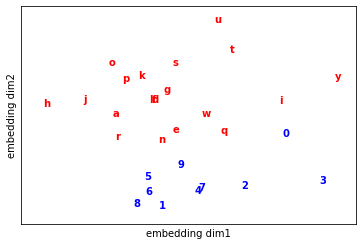

In [48]:
if __name__ == "__main__":
    d = process_w2v_data(corpus,skip_window=2, method="cbow")
    m = CBOW(d.num_word, 2)
    train(m,d)
    #show_w2v_word_embedding(m,d,"./visual/results/cbow.png")
    show_w2v_word_embedding(m,d)

In [49]:
from torch.utils.data import Dataset as tDataset
tDataset

torch.utils.data.dataset.Dataset

In [55]:
d.sample(30)

(array([[17,  7,  8, 20],
        [10, 11,  2, 11],
        [15, 22, 19,  0],
        [14,  1,  5, 23],
        [ 6, 13,  7, 20],
        [ 5, 14, 23,  5],
        [11, 15, 27, 19],
        [12, 25,  3,  1],
        [11, 15, 27, 19],
        [ 5, 23, 23, 14],
        [ 5, 14, 23,  5],
        [19, 20, 13, 18],
        [ 4,  8, 15, 10],
        [ 4,  2, 18,  8],
        [17,  7,  8, 20],
        [13, 17, 15,  4],
        [13,  2, 21,  8],
        [13, 17, 20, 11],
        [17,  4,  7, 18],
        [19, 22, 13,  2],
        [16,  3,  5, 14],
        [29,  0, 15,  0],
        [16,  3, 16, 16],
        [26, 26, 19, 22],
        [ 6, 13,  7, 15],
        [14, 23,  5,  1],
        [ 1,  1,  5,  9],
        [27, 19, 19,  4],
        [21, 10, 24,  2],
        [17,  7,  8, 20]]),
 array([ 6, 24, 27, 23, 17,  1, 22,  9, 22, 14,  1,  0, 24,  7,  6,  7,  6,
         7,  2, 17, 25,  0,  0,  4, 17, 14, 23,  0, 11,  6]))